# VIX index
In this document we are going to calculate the VIX, that is a specific index calculated by the CBOE and it is defined as the market's expectation of the implied volatility calculated on the sp500 out-of-money options with a 30-days forward looking.
The calculation are done by following the CBOE procedure with the two listed methods

It gives a panoramic of the implied volatility for the enxt period.
It is expressed in annualized percentages and if it is:
- $<15 \%$ the VIX is low;
- $15-25$ the VIX is normal;
- $ > 25 \%$ the VIX is high.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime


## General EDA

First I need the options calls and puts.
The estimation is done on the sp500 options like the CBOE as defined.
This is because it is the benchmark index of the large-cap USA companies and it is the better one to express the market sentiment.

In [67]:
sp500= yf.Ticker("SPY")
expiration= sp500.options
chosen_date_t1= expiration[11]
chosen_date_t2= expiration[15]
expiration

('2025-02-04',
 '2025-02-05',
 '2025-02-06',
 '2025-02-07',
 '2025-02-10',
 '2025-02-11',
 '2025-02-12',
 '2025-02-13',
 '2025-02-14',
 '2025-02-21',
 '2025-02-28',
 '2025-03-07',
 '2025-03-14',
 '2025-03-21',
 '2025-03-31',
 '2025-04-17',
 '2025-04-30',
 '2025-05-16',
 '2025-05-30',
 '2025-06-20',
 '2025-06-30',
 '2025-07-18',
 '2025-07-31',
 '2025-08-15',
 '2025-09-19',
 '2025-09-30',
 '2025-12-19',
 '2025-12-31',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15',
 '2027-12-17')

In [68]:
def get_options(chosen_date, data, condition):
  options= data.option_chain(chosen_date)
  if condition== "calls":
    calls_op= options.calls.dropna()
    return calls_op
  else:
    puts_op=options.puts.dropna()
    return puts_op


calls_op_t1= get_options(chosen_date_t1, sp500, "calls")
puts_op_t1= get_options(chosen_date_t1, sp500, "puts")
calls_op_t2 = get_options(chosen_date_t2, sp500, "calls")
puts_op_t2= get_options(chosen_date_t2, sp500, "puts")

In [69]:
chosen_date_t1, chosen_date_t2

('2025-03-07', '2025-04-17')

In [70]:
spot_price = sp500.history(period="1d")["Close"].iloc[-1]

Then, I need to calculate the mid price that is the $\frac{bid+ask}{2}$.
The mid price is one of the element of the formula to estimate the VIX.
I have defined this function ```mid_price()``` to do this job for the two different maturities.



In [71]:
def mid_price(data):
  data["mid_price"]= (data["bid"]+ data["ask"]) / 2
  return data["mid_price"]
calls_op_t1["mid_price"]= mid_price(calls_op_t1)
puts_op_t1["mid_price"]= mid_price(puts_op_t1)
calls_op_t2["mid_price"]= mid_price(calls_op_t2)
puts_op_t2["mid_price"]= mid_price(puts_op_t2)

In addition, I have to select the out-of-money options by appling the filter method.

So, thanks to the function ```otm_calculation()``` I'm going to choose the put options for which the $K < S_t$ and teh call for which the $K > S_t$.

It is another important element for the formula of the VIX.

In [72]:
def otm_calculation(data, condition):
  if condition== "calls":
    data_otm= data[data['strike'] > spot_price]
    return data_otm
  else:
    data_otm= data[data['strike'] < spot_price]
    return data_otm
calls_otm_t1= otm_calculation(calls_op_t1, "calls")
puts_otm_t1= otm_calculation(puts_op_t1, "puts")
calls_otm_t2= otm_calculation(calls_op_t2, "calls")
puts_otm_t2= otm_calculation(puts_op_t2, "puts")




In [73]:
def otm_options(call,put):
  otm_options=pd.concat([call,put]).sort_values('strike')
  return otm_options

otm_options_t1= otm_options(calls_otm_t1,puts_otm_t1)
otm_options_t2= otm_options(calls_otm_t2,puts_otm_t2)

I've estimated also the call price and the put price that are given by the option that has the lowest absolute difference between the spot price and the strike price for both of them.

So, basically we are looking for the most ATM option.

They are useful to calculate the forward price.



In [74]:
# Get common strikes between calls and puts
common_strikes_t1 = np.intersect1d(calls_op_t1["strike"], puts_op_t1["strike"])
common_strikes_t2 = np.intersect1d(calls_op_t2["strike"], puts_op_t2["strike"])
closest_strike_t1 = common_strikes_t1[np.argmin(np.abs(common_strikes_t1- spot_price))]
closest_strike_t2 = common_strikes_t2[np.argmin(np.abs(common_strikes_t2- spot_price))]
# Filter options at the closest strike
call_price_t1 = calls_op_t1[calls_op_t1["strike"] == closest_strike_t1]["mid_price"].values[0]
put_price_t1 = puts_op_t1[puts_op_t1["strike"] == closest_strike_t1]["mid_price"].values[0]
call_price_t2 = calls_op_t2[calls_op_t2["strike"] == closest_strike_t2]["mid_price"].values[0]
put_price_t2 = puts_op_t2[puts_op_t2["strike"] == closest_strike_t2]["mid_price"].values[0]
call_price_t1, put_price_t1, closest_strike_t1


(11.195, 9.015, 600.0)

In [75]:
current_time = datetime.now()
def get_time_to_maturity(exp_date_str):
    exp_date = datetime.strptime(exp_date_str, "%Y-%m-%d")
    delta = exp_date - current_time
    return delta.total_seconds() / 60
weight1=get_time_to_maturity(chosen_date_t1)
weight2=get_time_to_maturity(chosen_date_t2)
T1 = get_time_to_maturity(chosen_date_t1)/ (525600)
T2 = get_time_to_maturity(chosen_date_t2) / 525600
weight1

43553.22033546666

## **VIX Formula**
So, now thanks all the elements that we have at our disposal, we can estimate the VIX using its formula:
$
VIX = 100 \times \sqrt{T \sum \left( \frac{\Delta K_i}{K_i^2} e^{RT} Q(K_i) \right) - \frac{1}{T} \left( \frac{F}{K_0} - 1 \right)^2}
$
where:  
- $ T $ is time to expiration  
- $ K_i $ are the option strikes  
- $ \Delta K_i $ is the difference between strikes  
- $ F $ is the forward price  
- $ Q(K_i) $ is the mid-price of OTM option  
- $R$ is the risk-free rate (assumed to be equal to 0.0485)
- $K_0$ is the first strike below $F$

In [76]:
def vix_index(otm_options, call_price,put_price, time_to_maturity, risk_free_rate):

  forward_price= otm_options["strike"].iloc[0]+np.exp(risk_free_rate*time_to_maturity)*(call_price-put_price)

  otm_options['delta_k'] = otm_options['strike'].diff().fillna(0)
  otm_options['weight'] = (
        (2 / time_to_maturity) * otm_options['delta_k'] / otm_options['strike']**2
    )

  weighted_variance = np.sum(
        otm_options['weight'] * np.exp(risk_free_rate * time_to_maturity) * otm_options['mid_price']
    )

  forward_variance = weighted_variance - (1 / time_to_maturity) * (forward_price / otm_options['strike'].iloc[0] - 1)**2
  vix = 100*np.sqrt(forward_variance)

  return vix, forward_variance
vixnear=vix_index(otm_options_t1, call_price_t1, put_price_t1, T1, risk_free_rate=0.0485)
vixfar=vix_index(otm_options_t2, call_price_t2, put_price_t2,T2, risk_free_rate=0.0485)
vixnear, vixfar

((17.171964718161774, 0.029487637228179285),
 (17.87849705391158, 0.031964065690672505))

This is the second approach for VIX calculation.
It uses the forward variance calculated above for the near-terms options and the next-term options.


$
\text{Volatility Index} = 100 \times \sqrt{ T_1 \sigma_1^2 \left[ \frac{M_{T2} - M_{CM}}{M_{T2} - M_{T1}} \right] + T_2 \sigma_2^2 \left[ \frac{M_{CM} - M_{T1}}{M_{T2} - M_{T1}} \right] } \times \frac{M_{365}}{M_{CM}}
$

where:  
- $ T_1, T_2 $ are the times to expiration,  
- $\sigma_1, \sigma_2 $ are the volatilities of near-term and far-term options,  
- $ M_{T1}, M_{T2} $ are the times in minutes for near-term and far-term options,  
- $ M_{CM} $ is the constant maturity time in minutes (typically 43200 for 30 days),  
- $M_{365}$ represents the number of minutes in a year (525600).

In [77]:
w1= (weight2-43200) / (weight2-weight1)
w2= (43200-weight1) / (weight2-weight1)
vix= 100*np.sqrt((w1*vixnear[1]*T1+w2*vixfar[1]*T2)*525600/43200)
vix

17.161716704892015

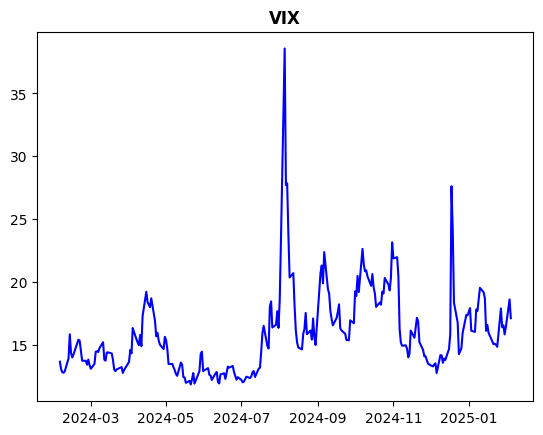

In [78]:
vix_t= yf.Ticker("^VIX")
actual_vix= vix_t.history(period="1d")["Close"].iloc[-1]
actual_vix
plt.figure()
plt.plot(vix_t.history(period="1y")["Close"], color="blue")
plt.title('VIX', fontweight='bold')
plt.show()

In [79]:
actual_vix

17.1299991607666

##Conclusions
In both cases we have reached a good approximation of the VIX.
It is in the normal range and it basically means that the market is quite "stable".
It could have peaks or downturn movements, but in general the market's expectation on future implied volatility are not so much bad.

Under these conditions having a **straddle** it could be a good way to work, because we expect a movement, maybe a large movement, but we do not know in which direction it will happen.

Obviously, it depends on further analysis!

